# Семинар 3 - linear regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

Поработаем с линейной регрессией на практике с помощью библиотеки [scikit-learn](https://scikit-learn.org/stable/). Эта библиотека включает в себя множество алгоритмов, разные тестовые наборов данных, функции для подсчета метрик и подбора параметров, а также многое другое.

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Данные
Для демонстраций загрузим набор данных [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/Automobile). В данных присутствуют категориальные, целочисленные и вещественнозначные признаки. 

[Скачаем](https://raw.githubusercontent.com/AKuzina/ml_dpo/main/practicals/automobiles.csv) данные и прочитаем:

In [3]:
X_raw = pd.read_csv('automobiles.csv', na_values=["?"])
X_raw.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


**Задание 1** Создайте отдельно вектор с целевой переменной (столбец `price`) и удалите его из таблицы `X_raw`.

In [4]:
# your code here
y = X_raw['price']
X_raw = X_raw.drop('price', axis=1)

## Предобработка данных
Предобработка данных важна при применении любых методов машинного обучения, а в особенности для линейных моделей. В sklearn предобработку удобно делать с помощью различных модулей (например, [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)) или методов библиотеки pandas.

### Заполнение пропусков
В матрице объекты-признаки могут быть пропущенные значения, и это вызовет ошибку при попытке передать такую матрицу в функцию обучения модели или даже предобработки. Если пропусков немного, можно удалить объекты с пропусками из обучающей выборки. Заполнить пропуски можно [разными способами](https://scikit-learn.org/stable/modules/impute.html), например:

* заполнить средними (mean, median);
* предсказывать пропущенные значения по непропущенным.

Последний вариант сложный и применяется редко. Для заполнения константами можно использовать метод датафрейма `fillna`, для замены средними - класс [`impute.SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) (в более старых версиях `scikit-learn` - `preprocessing.Imputer`).

Рассмотрим пример его работы (из документации).

In [5]:
array1 = np.array([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])
array2 = np.array([[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]])

print(array1)
print(array2)

[[ 7.  2.  3.]
 [ 4. nan  6.]
 [10.  5.  9.]]
[[nan  2.  3.]
 [ 4. nan  6.]
 [10. nan  9.]]


In [6]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [7]:
# нельзя делаять transform до fit
imp_mean.transform(array2)

NotFittedError: This SimpleImputer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [8]:
# fit посчитает нужные средние по данным
imp_mean.fit(array1)

SimpleImputer()

In [9]:
# transform заполнит посчитанными средними пропущенные значение
imp_mean.transform(array2)

array([[ 7. ,  2. ,  3. ],
       [ 4. ,  3.5,  6. ],
       [10. ,  3.5,  9. ]])

In [10]:
# иногда удобно совмещать оба шага в один
imp_mean.fit_transform(array1)

array([[ 7. ,  2. ,  3. ],
       [ 4. ,  3.5,  6. ],
       [10. ,  5. ,  9. ]])

---
Вернемся к нашим данным. Для начала избавимся от наблюдений, у которых пропущена целевая переменная



In [11]:
print(y.isna().sum())

drop_idx = np.where(y.isna())[0]
print(drop_idx)

4
[  9  44  45 129]


In [12]:
y.drop(index = drop_idx, inplace=True)
X_raw.drop(index = drop_idx, inplace=True)

**Задание 2** Посчитайте число пропусков в каждом столбце

In [13]:
# your code here
X_raw.isna().sum()

symboling             0
normalized-losses    37
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
dtype: int64

**Задание 3** Заполните пропуски в данных. Обратите внимание, что `SimpleImputer` возвращает массив, создайте из него `DataFrame`.

In [14]:
# для удобства работы с нашим датасетом создаем маску, указывающую на столбцы с категориальными признаками
cat_features_mask = (X_raw.dtypes == "object").values # категориальные признаки имеют тип "object"
cat_features_mask

array([False, False,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False,  True,  True, False,  True,
       False, False, False, False, False, False, False])

In [15]:
X_real = X_raw[X_raw.columns[~cat_features_mask]]
X_cat = X_raw[X_raw.columns[cat_features_mask]]

# для вещественнозначных признаков заполним пропуски средними значениями
mis_replacer = SimpleImputer(strategy="mean")

# для категориальных - пустыми строками
cat_replacer = SimpleImputer(strategy="constant", fill_value="")


X_no_nans_real = pd.DataFrame(data=mis_replacer.fit_transform(X_real), columns=X_real.columns) # your code here
X_cat = pd.DataFrame(data=cat_replacer.fit_transform(X_cat), columns=X_cat.columns) # your code here


X_no_nans = pd.concat([X_no_nans_real, X_cat], axis=1)
X_no_nans.isna().sum()

symboling            0
normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
engine-type          0
num-of-cylinders     0
fuel-system          0
dtype: int64

Всегда нужно осознавать, случайны ли пропуски в каком-то признаке. Иногда факт отсутствия информации о значении признака может сам быть важным признаком, который необходимо добавить к другим признакам.

__Пример:__ предсказание возраста пользователя по данным с его телефона. Поскольку люди старшего возраста чаще пользуются простыми телефонами, факт отсутствия каких-то данных (например, истории посещенных интернет-страниц), скорее всего, будет хорошим признаком.

Для категориальных признаков рекомендуется создавать отдельную категорию, соответствующую пропущенному значению.

---
### Масштабирование признаков
В ходе предобработки данных часто рекомендуется приводить все признаки к одному масштабу. Это важно по нескольким причинам:

* ускорение обучения модели;
* улучшение численной устойчивости при работе с матрицей объекты-признаки;
* для линейных моделей: интерпретация весов при признаках как меры их значимости.

(полезная ссылка: https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0)

Первый популярный способ масштабирования - нормализация: вычитание среднего из каждого признака и деление на стандартное отклонение ([`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) в sklearn). Второй популярный способ: вычитание минимума из каждого признака, а затем деление на разницу максимального и минимального значения ([`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) в sklearn).

**Задание 4** Отмасштабируйте числовые признаки в данных, используя `MinMaxScaler`

In [16]:
# your code here
scaler = MinMaxScaler()

# select only numerical features
num_features_mask = ~(X_no_nans.dtypes == "object").values

# transform and convert back to Pandas DataFrame
X_norm = scaler.fit_transform(X_no_nans[X_no_nans.columns[num_features_mask]])
X_norm = pd.DataFrame(X_norm, columns=X_no_nans.columns[num_features_mask])
X_norm.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474
1,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474
2,0.6,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158
3,0.8,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421
4,0.8,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895



### Преобразование нечисловых признаков
Практически все методы машинного обучения требуют, чтобы на вход функции обучения подавалась вещественная матрица. В процессе обучения используются свойства вещественных чисел, в частности, возможность сравнения и применения арифметических операций. Поэтому, даже если формально в матрице объекты-признаки записаны числовые значения, нужно всегда анализировать, можно ли относиться к ним как к числам. 

__Пример:__ некоторые признаки могут задаваться целочисленными хешами или id (например, id пользователя соц. сети), однако нельзя сложить двух пользователей и получить третьего, исходя из их id (как это может сделать линейная модель).

К категориальным признакам, принимающим значения из неупорядоченного конечного множества $K$, часто применяют [one-hot encoding](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) (вместо одного признака создают $K$ бинарных признаков - по одному на каждое возможное значение исходного признака). Правда, нужно понимать, что создание $K$ таких признаков приведет к [мультиколлинеарности](https://ru.wikipedia.org/wiki/%D0%9C%D1%83%D0%BB%D1%8C%D1%82%D0%B8%D0%BA%D0%BE%D0%BB%D0%BB%D0%B8%D0%BD%D0%B5%D0%B0%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%8C), и поэтому в зависимости от применяемой модели может быть стоит [убрать один из них](https://stats.stackexchange.com/questions/231285/dropping-one-of-the-columns-when-using-one-hot-encoding) (и оставить $K - 1$ признак).

В `sklearn` one-hot кодирование можно сделать с помощью класса [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), а можно использовать функцию [`pd.get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html).


Следует заметить, что в новой матрице будет очень много нулевых значений. Чтобы не хранить их в памяти, можно задать параметр `OneHotEncoder(sparse=True)` или `.get_dummies(sparse=True)`, и метод вернет [разреженную матрицу](http://docs.scipy.org/doc/scipy/reference/sparse.html), в которой хранятся только ненулевые значения. Выполнение некоторых операций с такой матрицей может быть неэффективным, однако большинство методов sklearn умеют работать с разреженными матрицами.

In [17]:
# Apply get_dummies to caategoical feature only
X_dum = pd.get_dummies(X_no_nans[X_no_nans.columns[~num_features_mask]], drop_first=True)
print(X_dum.shape)

# combine OHE categorical and scaled numerical features
X = pd.concat([X_norm, X_dum], axis=1)

(201, 50)


---
__Вопрос__: стоит ли применять one-hot encoding для признаков с большим числом категорий (например, id)? Почему?

---

Помимо категориальных признаков, преобразования требуют, например, строковые признаки. Их можно превращать в матрицу частот слов с помощью [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), матрицу частот буквосочетаний фиксированной длины, можно извлекать другие признаки (например, длина строки).


### Добавление признаков
Особенно важным моментом для линейной регрессии является нелинейное преобразование признаков. Это позволяет использовать линейную регрессию для моделирования нелинейных зависимостей. Из популярных преобразований можно выделить следующие: полиномиальные признаки ([`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) в sklearn), взятие логарифма, квадратного корня, применение тригонометрических функий.

Например, в нашем датасете зависимость целевой переменной от признака 'curb-weight' скорее квадратичная, чем линейная:

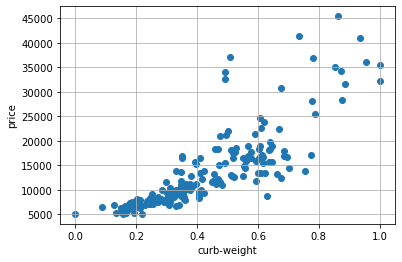

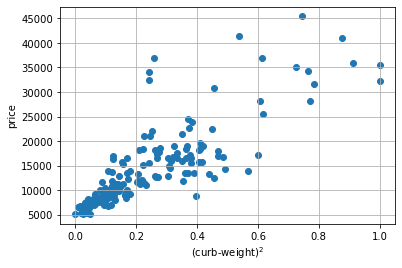

In [18]:
plt.scatter(X['curb-weight'], y)
plt.xlabel('curb-weight')
plt.ylabel('price')
plt.grid()
plt.show();

plt.scatter(X['curb-weight']**2, y)
plt.xlabel('(curb-weight)$^2$')
plt.ylabel('price')
plt.grid()
plt.show();

А для признака `highway-mpg` линеаризовать зависимость получается с помощью функции $\frac 1 {\sqrt{\cdot}}$

**Задание 5** Постройте график зависимсти цены от признака `highway-mpg`, преобразованного с помощью функции $\frac 1 {\sqrt{\cdot}}$. Является ли полученная зависимость линейной?

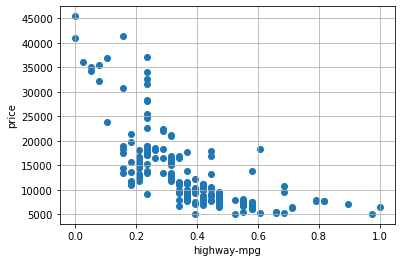

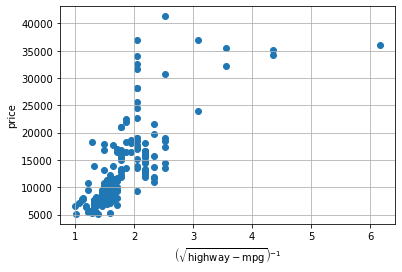

In [19]:
plt.scatter(X['highway-mpg'], y)
plt.xlabel('highway-mpg')
plt.ylabel('price')
plt.grid()
plt.show()

# your code here
plt.scatter(1 / np.sqrt(X['highway-mpg']), y)
plt.xlabel('$\\left(\sqrt{\\mathrm{highway-mpg}}\\right)^{-1}$')
plt.ylabel('price')
plt.grid()
plt.show()

Обратите внимание, что при генерации полиномиальных признаков матрица объекты-признаки может занимать очень много памяти.

## Линейная регрессия

Находится сабмодуле `sklearn.linear_model`. Для обучения обычной модели регрессии с MSE используют класс `LinearRegression()`. Класс `SGDRegressor()` позволяет использовать другие фукции потерь при обучении.

Функционал качества в задачах обучения с учителем обычно задается в виде суммы по объектам выборки:
$$Q(a, X) = \frac 1 \ell \sum_{i=1}^\ell L(y_i, a(x_i)),$$
где $L(\cdot, \cdot)$ - функция потерь, задающая штраф за разницу между предсказанием и истинным значением целевого признака.


In [20]:
from sklearn.model_selection import train_test_split
# разделим данные на train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

In [21]:
# инициализация модели. На этом этапе задаются все гиперпараметры модели (есть они есть)
lr = LinearRegression() 

# обучение на обучающей выборке (метод `fit`)
lr.fit(X_train, y_train) 

# чтобы сделать прогноз используют метод `predict`
y_predicted = lr.predict(X_test) 

# теперь можно посчитать ошибку на тесте
error = np.mean( (y_predicted - y_test)**2 )
print(error)

3.2878550327262875e+31


## Функции потерь в регрессии
Как отмечалось на первой лекции, функционал качества должен в первую очередь отвечать требованиям заказчика, при этом математические свойства функции потерь могут быть неудобны для оптимизации. 

### Среднеквадратичная и средняя абсолютная ошибка
Кроме требований заказчика, функционал качества должен учитывать математические особенности модели - например, устойчивость к шумовым объектам. В линейной регрессии функция потерь $L(y_i, a(x_i)) = (a(x_i) - y_i)^2$ не обладает этим свойством, потому что задает очень большие штрафы за большие отклонения от фактического значения. 

Рассмотрим это явление на примере. Предскажем значения признака 'make_audi' по признаку 'engine-size' с помощью линейной регрессии. Добавим к выборке два объекта-выброса и посмотрим, как изменится оптимальная с точки зрения MSE прямая.

In [22]:
X_subset = X[['engine-size']].values
y_subset = X[['make_audi']].values

# добавление двух шумовых точек
X_subset_modified = np.vstack((X_subset, np.array([[1], [2]]))) 

y_subset_modified = np.vstack((y_subset, np.array([[90], [50]]) )) 

---
**Задание 6** Заполните пропуски в фукции, которая обучаеи и визуализирует линейную регрессию с 1 переменной. Запустите ячейку которая рисует графики и обсудите, что вы на них видите. 

In [23]:
def plot_lr_MSE(X, y):
    # визуализируем точки
    plt.scatter(X, y)  
    
    # обучим линейную модель
    # your code here
    lr = LinearRegression()
    lr.fit(X, y) 
    
    # визуализируем прямую
    grid = np.linspace(0, 2, 100)
    line = lr.predict(grid[:, np.newaxis])
    plt.plot(grid, line)   

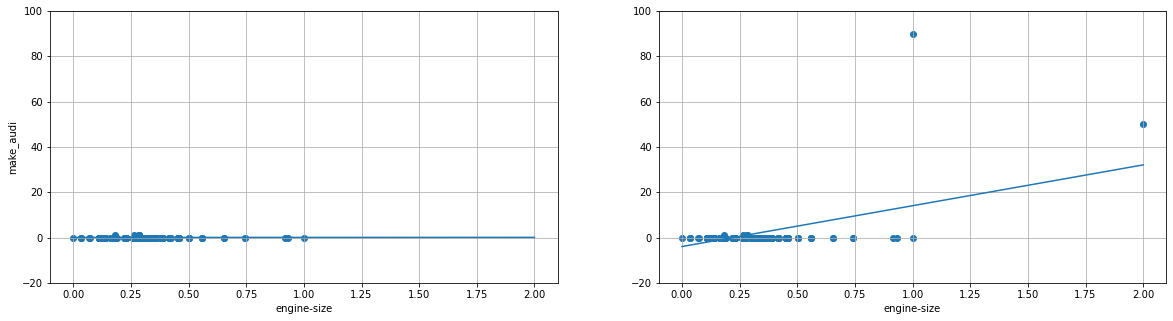

In [24]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)

plot_lr_MSE(X_subset, y_subset)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.ylabel('make_audi')
plt.grid()

plt.subplot(1, 2, 2)
plot_lr_MSE(X_subset_modified, y_subset_modified)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.grid();

Из-за шумовых объектов прямая достаточно сильно изменила наклон. Поэтому вместо MSE можно использовать Mean Absolute Error: $L(y_i, a(x_i)) = |a(x_i) - y_i|$:

Теперь обучим регрессию, оптимизируя MAE. 
---
**Задание 7** Заполните пропуски в фукции, которая обучаеи и визуализирует линейную регрессию с 1 переменной и MAE. Запустите ячейку с построением графиком, прокоментируйте результат

In [25]:
def plot_lr_MAE(X, y):
    # визуализируем точки
    plt.scatter(X, y)   
    
    # обучим линейную модель с MAE
    lr_mae = SGDRegressor(loss='epsilon_insensitive', epsilon=0)
    # your code here
    lr_mae.fit(X, y)
    
    # визуализируем прямую
    # your code here
    grid = np.linspace(0, 2, 100)
    line = lr_mae.predict(grid[:, np.newaxis])
    plt.plot(grid, line)  

/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


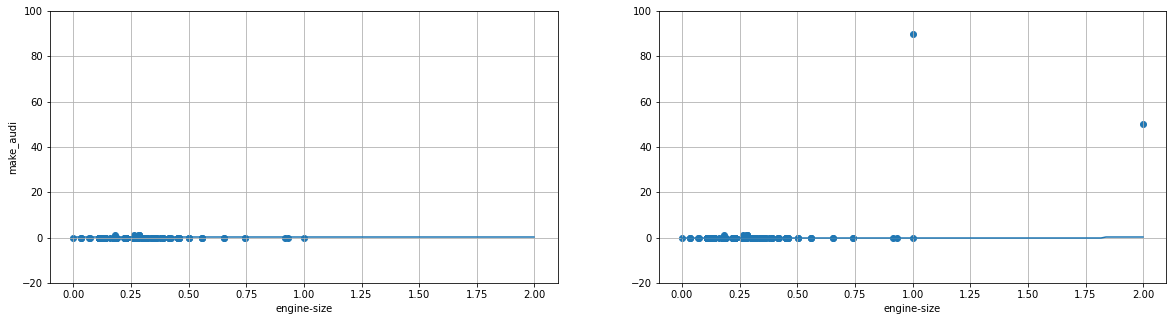

In [26]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plot_lr_MAE(X_subset, y_subset)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.ylabel('make_audi')
plt.grid()


plt.subplot(1, 2, 2)
plot_lr_MAE(X_subset_modified, y_subset_modified)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.grid();

Прямая не изменила направление из-за выбросов.

Попробуем добавить больше шумовых объектов:

/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


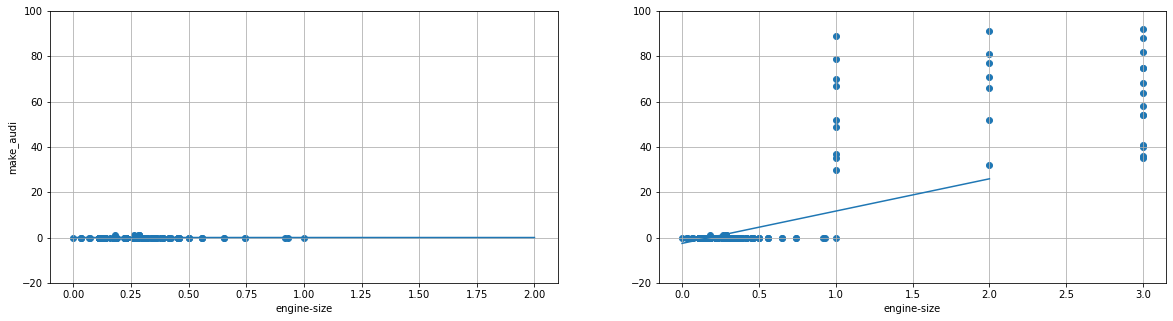

In [27]:
np.random.seed(13)
# добавление 30 шумовых точек (попробуйте поменять число и посмотреть на результат)
N_noisy = 30
X_subset_modified_twice = np.vstack((X_subset,  np.random.randint(1, 4, size=N_noisy).reshape(-1, 1))) 
y_subset_modified_twice = np.vstack((y_subset, np.random.randint(30, 100, size=N_noisy).reshape(-1, 1))) 



plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plot_lr_MAE(X_subset, y_subset)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.ylabel('make_audi')
plt.grid()


plt.subplot(1, 2, 2)
plot_lr_MAE(X_subset_modified_twice, y_subset_modified_twice)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.grid();

Прямая изменила наклон, когда мы добавили 30 (почти 15%) шумовых точек.

### Huber Loss
Иногда используют Huber Loss - "гибрид" MAE и MSE, который, как и MAE, устойчив к шумовым объектам, и как и MSE, мало штрафует малые отклонения от фактического значения целевого признака:
$$L(y_i, a(x_i)) = \phi_\varepsilon(a(x_i) - y_i)$$
$$\phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}$$

Оптимизация Huber Loss реализована в sklearn:

In [28]:
from sklearn.linear_model import HuberRegressor
# or
# SGDRegressor(loss='huber')

**Задание 8** Обучите линейную регрессию с HuberLoss (используя все доступные признаки и целевую переменную price). Посчитайте ошибку на тесте.

In [29]:
# инициализация модели. На этом этапе задаются все гиперпараметры модели (есть они есть)
lr = SGDRegressor(loss='huber')

# обучение на обучающей выборке (метод `fit`)
lr.fit(X_train, y_train) 

# чтобы сделать прогноз используют метод `predict`
y_predicted = lr.predict(X_test) 

# теперь можно посчитать ошибку на тесте
error_huber = np.mean( (y_predicted - y_test)**2 )

print('Error with Huber Loss', error_huber)

Error with Huber Loss 347483532.7244336


/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Ниже можно видеть, что Huber loss отлично справляется с выбросами. 

In [30]:
def plot_lr_Huber(X, y):
    # визуализируем точки
    plt.scatter(X, y)   
    
    # обучим линейную модель с MAE
    lr_mae = SGDRegressor(loss='huber')
    # your code here
    lr_mae.fit(X, y)
    
    # визуализируем прямую
    # your code here
    grid = np.linspace(0, 2, 100)
    line = lr_mae.predict(grid[:, np.newaxis])
    plt.plot(grid, line)  

/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


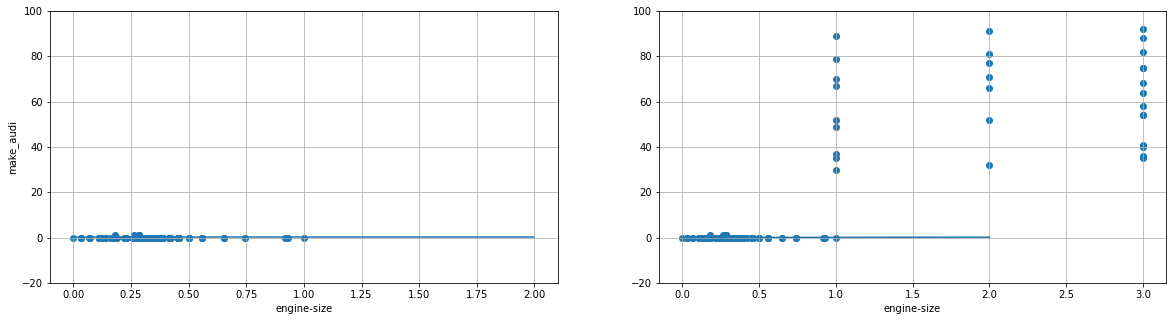

In [31]:
np.random.seed(13)
# добавление 30 шумовых точек (попробуйте поменять число и посмотреть на результат)
N_noisy = 30
X_subset_modified_twice = np.vstack((X_subset,  np.random.randint(1, 4, size=N_noisy).reshape(-1, 1))) 
y_subset_modified_twice = np.vstack((y_subset, np.random.randint(30, 100, size=N_noisy).reshape(-1, 1))) 



plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plot_lr_Huber(X_subset, y_subset)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.ylabel('make_audi')
plt.grid()


plt.subplot(1, 2, 2)
plot_lr_Huber(X_subset_modified_twice, y_subset_modified_twice)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.grid();

---
Сравним три рассмотренные функции потерь:

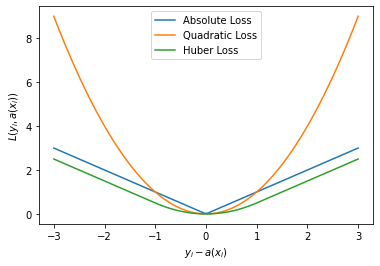

In [32]:
grid = np.linspace(-3, 3, 100)
quantile_tau = 0.2
mse_loss = grid ** 2
mae_loss = np.abs(grid)
huber_loss = 0.5 * mse_loss * (grid >= -1) * (grid <= 1) + (mae_loss - 0.5) * (grid < -1) + (mae_loss - 0.5)  * (grid > 1)

plt.plot(grid, mae_loss, label="Absolute Loss")
plt.plot(grid, mse_loss, label="Quadratic Loss")
plt.plot(grid, huber_loss, label="Huber Loss")

plt.xlabel("$y_i - a(x_i)$")
plt.ylabel("$L(y_i, a(x_i))$")
plt.legend()
plt.show()

## Lasso and Ridge 

Вернемся к нашей задаче предсказания цены. Обучим тепель линейную регрессию с $L_1$ и $L_2$ регуляризациями. Обе модели находятся сабмодуле `sklearn.linear_model`. 

In [33]:
from sklearn.linear_model import Lasso, Ridge

Напомним, как выглядит функционал для обучения Lasso:
$$
\frac{1}{l}\|X w - y\|^2  + \lambda \sum_{i=1}^d|w_i| \rightarrow \min_w
$$

$\lambda $ - гиперпараметр, в `sklearn` для его обозначения чаще всего используется аргумент `alpha`

In [34]:
# initialize the model and set the hyperparameters
lasso = Lasso(alpha=1)

# train
lasso.fit(X_train, y_train)

# predict 
y_predicted = lasso.predict(X_test) 


print('Error', np.mean( (y_predicted - y_test)**2)**0.5)

Error 2169.7131804951628


/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1257919.6455919743, tolerance: 831821.7486743751
  positive)


In [35]:
# initialize the model and set the hyperparameters
ridge = Ridge(alpha=1)

# train
ridge.fit(X_train, y_train)

# predict 
y_predicted = ridge.predict(X_test) 


print('Error', np.mean( (y_predicted - y_test)**2)**0.5)

Error 2301.848033908679


---
__Вопрос__: можно ли я сравнивать ошибку на тесте для разных моделей и на ее основании выбирать лучшую?

---

![im](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [36]:
from sklearn.model_selection import cross_val_score

Функция `cross_val_score` имеет следующие аргументы:
 - estimator (model or the whole pipeline)
 - training data
 - количество фолдов
 - метрика качества

In [37]:
# possible scorers
import sklearn.metrics
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [38]:
cv_res = cross_val_score(estimator=lasso, X=X_train, y=y_train, cv=5, scoring='neg_mean_squared_error')
print(cv_res)

[-12963825.58876866  -6104763.95533875 -31237843.40025784
  -8394943.65500893  -7287265.87335407]


/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2006710.6544646323, tolerance: 669167.982296875
  positive)
/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6976886.339698255, tolerance: 625966.5121500001
  positive)
/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1598900.184177488, tolerance: 695942.316421875
  positive)
/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: Con

In [39]:
print('CV score for lasso: {:.2f}'.format(-np.mean(cv_res)))

CV score for lasso: 13197728.49


**Задание 9** Используя `cross_val_score` сравните 
- Линейную регрессию с MSE
- Линейную регрессию с Huber Loss
- Lasso регрессию 
- Ridge регрессию 


In [40]:
# your code here
models = [LinearRegression(), SGDRegressor(loss='huber'), Lasso(), Ridge()]
all_scores = []
for m in models:
    scores = cross_val_score(estimator=m, X=X_train, y=y_train, cv=5, scoring='neg_mean_squared_error')
    all_scores.append(-np.mean(scores))
print(all_scores)
print(np.argmin(all_scores))

/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/annakuzina/anaconda3/envs/BASE_ENV/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence.

[8.372423732733674e+30, 206761833.5548244, 13197728.494545652, 7980748.116489527]
3


**Задание 10** Для лучшей модели посчитайтк RMSE (Root Mean Squared Error) на тестовых данных. Проинтерпритируйте результат.

$$
RMSE = \sqrt{\frac1l\sum_{i=1}^l(y_1 - \hat{y}_i)}, \quad \hat{y}_i - \text{предсказанное моделью значение целевой переменной}
$$

In [41]:
#your code here
best_model = models[np.argmin(all_scores)]
best_model.fit(X_train, y_train)
best_model.predict(X_test)

print('RMSE Error', np.mean( (y_predicted - y_test)**2)**0.5)

RMSE Error 2301.848033908679
